In [89]:
%matplotlib inline
%pylab inline
import sympy as sym
import pylab as pl
import numpy as np
import numpy.polynomial.polynomial as n_poly
import numpy.polynomial.legendre as leg


import scipy
from scipy.interpolate import *
from scipy.integrate import *
from scipy.special import roots_legendre

from mpl_toolkits.mplot3d import Axes3D


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# EXERCISE 1 :  L2 projection

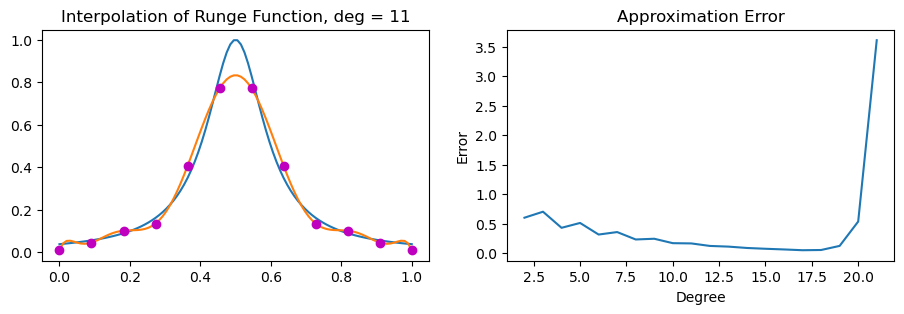

In [83]:
def basis(q):
    n = q.shape[0]
    L = [n_poly.Polynomial.fromroots([xj for xj in q if xj != q[i]]) for i in range(n)]
    L = [L[i]/L[i](q[i]) for i in range(n)]
    return L

def quadrature_rule(Nq):
    
    p,w = leg.leggauss(Nq)
    w = .5 * w
    p = .5*(p+1)
    W = np.diag(w)
    return p, W

def get_interpolating_function(LL, ui):
    def func(LL, ui, x):
        acc = 0
        for L, u in zip(LL, ui):
            # print(L, u)
            acc += u * L(x)
        return acc
    return lambda x: func(LL, ui, x)

def l2_projection(f, q, Nq):
    
    L = basis(q)
    p, W = quadrature_rule(Nq)
    
    B = np.zeros((0,Nq))
    for l in L:
        B = np.vstack([B,l(p)])
    M = B.dot(W.dot(B.T))
    p = p.reshape((p.shape[0],1))
    b = B.dot(W.dot(f(p)))
    
    u = np.linalg.solve(M, b)
    I = get_interpolating_function(L, u)
    
    return u, I

def main():
    t = sym.var('t')
    f = 1 / (1 + 100 * (t - 0.5)**2)
    Fd = f.diff(t, 1)
    
    f = sym.lambdify(t,f, 'numpy')
    F = sym.lambdify(t,Fd, 'numpy')
    
    deg = 11
    Nq = deg+1
    x = np.linspace(0,1,100)
    q = np.linspace(0,1,Nq)

    u,I = l2_projection(f, q, Nq)
    
    fig, axes = pl.subplots(1, 2, figsize=(11,3))

    axes[0].plot(x, f(x))
    axes[0].plot(x, I(x))
    axes[0].plot(q, u, 'mo')
    axes[0].set_title("Interpolation of Runge Function, deg = 11")

    degs = np.arange(2,22)
    errs = []
    for dg in degs:
        u,I = l2_projection(f, np.linspace(0,1,dg+1), dg+1)
        err = np.max(np.abs(f(x) - I(x)))
        errs.append(err)
    
    axes[1].plot(degs, errs)
    axes[1].set_xlabel('Degree')
    axes[1].set_ylabel('Error')
    axes[1].set_title('Approximation Error')

if __name__ == "__main__":
    main()

# EXERCISE 2 : Quadrature rules in 2D

In [91]:
def quadrature_rule(Nq):
    p, w = leg.leggauss(Nq)

    weights = .5 * w
    points = .5 * (p + 1)
    
    return points, weights

def tensor_product_quadrature_rule(n):
    
    points1, weights1 = quadrature_rule(n)
    points2, weights2 = quadrature_rule(n)

    points = np.array([[x, y] for x in points1 for y in points2])
    weights = np.outer(weights1, weights2).flatten()

    return points, weights

def main():
    deg = 11
    Nq = deg + 1
    points, weights = tensor_product_quadrature_rule(Nq)

    f = lambda x, y: 1/(1+100*((x-.5)**2+(y-.5)**2)) 
    integral = np.sum(weights * f(points[:, 0], points[:, 1]))

    print("Approximation:", integral)

if __name__ == "__main__":
    main()

Approximation: 0.10818401973908273


# FINAL PROJECT : 2D FEM Solver for Allen–Cahn equation

### 1D Solver


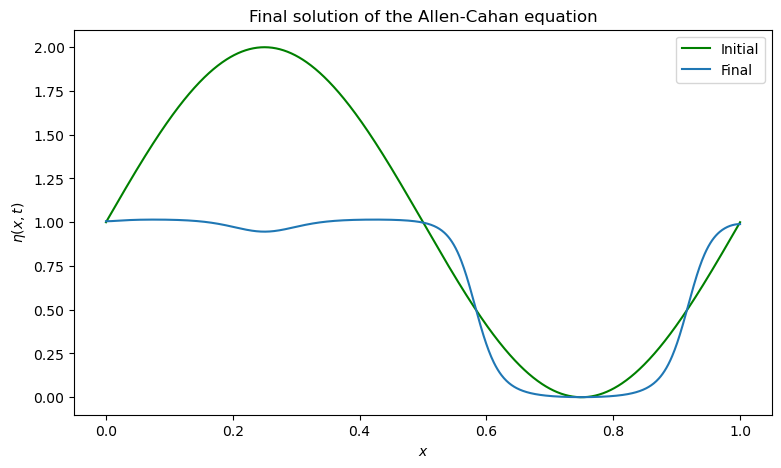

In [90]:

t = sym.var('t')
f = t**2 * (t - 1)**2
F = f.diff(t, 1)
F = sym.lambdify(t,F, 'numpy')


def solve_allen_cahan(eta_0_function, eps, dt, ndofs, degree):
    n_steps = int(1/dt) + 1   
    q = linspace(0, 1, ndofs) 
    
    basis = [PPoly.from_spline(splrep(q, np.eye(ndofs)[i], k=degree)) for i in range(ndofs)]
    
    intervals = unique(basis[0].x)
    
    qp, w = leg.leggauss(degree)
    qp = (qp + 1) / 2 
    w /= 2           
    
    h = diff(intervals)
    Q = array([intervals[i] + h[i] * qp for i in range(len(h))]).reshape((-1,))
    W = array([w * h[i] for i in range(len(h))]).reshape((-1,))
    
  
    m = len(basis)
    dbasis = []
    for i in range(m):
        dbasis.append(basis[i].derivative(1))
    
    Bq = array([basis[i](Q) for i in range(m)]).T
    dBq = array([dbasis[i](Q) for i in range(m)]).T
    
    M = einsum('qi, q, qj', Bq, W, Bq)
    K = einsum('qi, q, qj', dBq, W, dBq)    
    
    eta = zeros((n_steps, ndofs))
    eta[0] = eta_0_function(q)
    b = M.dot(eta[0] - dt * F(eta[0]))
    
    for i in range(1, n_steps):
        A = M + dt * eps**2 * K
        eta[i] = linalg.solve(A, b)
        b = M.dot(eta[i] - dt * F(eta[i]))
    
    return eta, basis


#SOLVE
eta, basis = solve_allen_cahan(lambda x: sin(2 * pi * x)+1, 0.01, 0.1, 100, 4)


def plot_final_solution(eta, basis,resolution):
    x = linspace(0, 1, resolution)
                 
    B = zeros((resolution, len(basis)))
    for i in range(len(basis)):
        B[:, i] = basis[i](x)
    
    p = eta[0] # INITIAL time step
    final_eta = eta[-1]  # FINAL time step
    
    plot(x, B.dot(p),'g', label = "Initial")
    plot(x, B.dot(final_eta), label = "Final")
    xlabel("$x$")
    ylabel("$\eta(x,t)$")
    title("Final solution of the Allen-Cahan equation")
    legend();
    

figure(figsize=(9, 5))
plot_final_solution(eta, basis, resolution=1000)

### 2D Solver

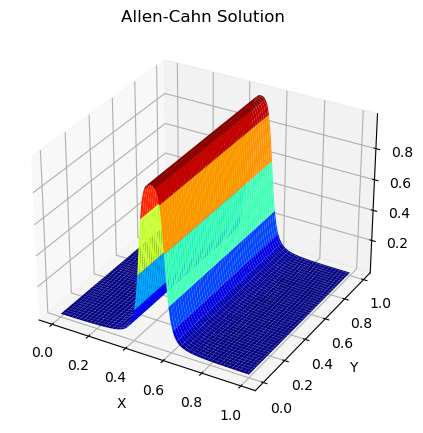

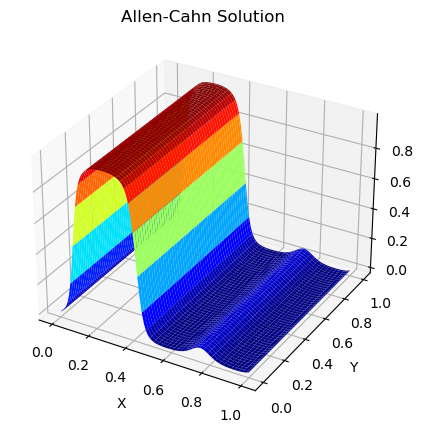

In [116]:
t = sym.var('t')
f = t**2 * (t - 1)**2
F = f.diff(t, 1)
F = sym.lambdify(t,F, 'numpy')


def solve_allen_cahan_2d(eta_0_function, eps, dt, ndofs, degree):
    n_steps = int(1 / dt) + 1
    q = linspace(0, 1, ndofs)
    y = linspace(0, 1, ndofs)

    basis = [PPoly.from_spline(splrep(q, np.eye(ndofs)[i], k=degree)) for i in range(ndofs)]
    basis = np.array(basis).T

    intervals = unique(basis[0].x)
    qp, w = leg.leggauss(degree)
    qp = (qp + 1) / 2
    w /= 2

    h = diff(intervals)
    Q = array([intervals[i] + h[i] * qp for i in range(len(h))]).reshape((-1,))
    W = array([w * h[i] for i in range(len(h))]).reshape((-1,))

    m = len(basis)
    dbasis = []
    for i in range(m):
        dbasis.append(basis[i].derivative(1))

    Bq = array([basis[i](Q) for i in range(m)]).T
    dBq = array([dbasis[i](Q) for i in range(m)]).T

    M = einsum('qi, q, qj', Bq, W, Bq)
    K = einsum('qi, q, qj', dBq, W, dBq)

    eta = zeros((n_steps, ndofs, ndofs))
    eta[0] = eta_0_function(q, y)
    b = M.dot(eta[0] - dt * F(eta[0]))

    for i in range(1, n_steps):
        A = M + dt * eps**2 * K
        eta[i] = linalg.solve(A, b)
        b = M.dot(eta[i] - dt * F(eta[i]))

    return eta, basis


def plot_solution(eta):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Allen-Cahn Solution')
    x, y = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
    ax.plot_surface(x, y, eta[-1], cmap='jet')
    plt.show()
    
def main(func):
    eta, basis = solve_allen_cahan_2d(func, 0.01, 0.1, 100, 4)
    plot_solution(eta)
    
func = lambda x,y: 1/(1+100*((x-.5)**2+(y-.5)**2))
func1 = lambda x,y: sin(2 * pi * x)+ 0*y

main(func)
main(func1)

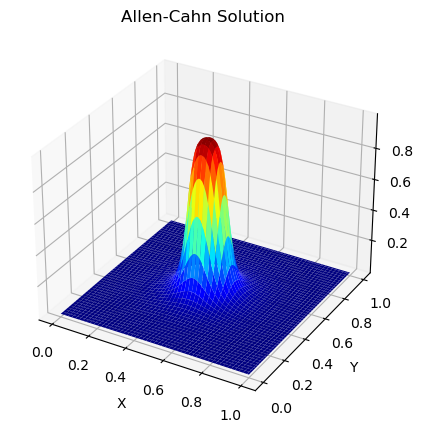

In [115]:
t = sym.var('t')
f = t**2 * (t - 1)**2
F = f.diff(t, 1)
F = sym.lambdify(t,F, 'numpy')


def solve_allen_cahan(eta_0_function, eps, dt, ndofs, degree):
    n_steps = int(1/dt) + 1   
    q = linspace(0, 1, ndofs) 
    x, y = np.meshgrid(q, q)
    
    basis = [PPoly.from_spline(splrep(q, np.eye(ndofs)[i], k=degree)) for i in range(ndofs)]
    
    intervals = unique(basis[0].x)
    
    qp, w = legendre.leggauss(degree)
    qp = (qp + 1) / 2 
    w /= 2           
    
    h = diff(intervals)
    Q = array([intervals[i] + h[i] * qp for i in range(len(h))]).reshape((-1,))
    W = array([w * h[i] for i in range(len(h))]).reshape((-1,))
    
  
    m = len(basis)
    dbasis = []
    for i in range(m):
        dbasis.append(basis[i].derivative(1))
    
    Bq = array([basis[i](Q) for i in range(m)]).T
    dBq = array([dbasis[i](Q) for i in range(m)]).T
    
    M = einsum('qi, q, qj', Bq, W, Bq)
    K = einsum('qi, q, qj', dBq, W, dBq)    
    
    eta = zeros((n_steps, ndofs, ndofs))
    eta[0] = eta_0_function(x, y)
    b = M.dot(eta[0] - dt * F(eta[0]))
    
    for i in range(1, n_steps):
        A = M + dt * eps**2 * K
        eta[i] = linalg.solve(A, b)
        b = M.dot(eta[i] - dt * F(eta[i]))
    
    return eta, basis


def plot_solution(eta):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Allen-Cahn Solution')
    x, y = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
    ax.plot_surface(x, y, eta[-1], cmap='jet')
    plt.show()
    
def main(func):
    eta, basis = solve_allen_cahan(func, 0.01, 0.1, 100, 4)
    plot_solution(eta)
    
func = lambda x,y: 1/(1+100*((x-.5)**2+(y-.5)**2))

main(func)

In [95]:
import numpy as np
from scipy.integrate import quad

def quadrature_rule(Nq):
    p, w = leg.leggauss(Nq)

    weights = .5 * w
    points = .5 * (p + 1)
    
    return points, weights

def tensor_product_quadrature_rule(n):
    
    points1, weights1 = quadrature_rule(n)
    points2, weights2 = quadrature_rule(n)

    points = np.array([[x, y] for x in points1 for y in points2])
    weights = np.outer(weights1, weights2).flatten()

    return points, weights

def basis(q):
    """Computes the basis functions."""
    return [PPoly.from_spline(splrep(q, np.eye(ndofs)[i], k=degree)) for i in range(ndofs)]

def M_ijkl(points, weights, basis):
    """Computes the M_ijkl tensor."""
    M1D = np.einsum('qi, q, qj', basis[i](points), weights, basis[j](points))
    M2D = M1D @ M1D
    return M2D

def K_ijkl(points, weights, basis):
    """Computes the K_ijkl tensor."""
    K1D = np.einsum('qi, q, qj', np.gradient(basis[i](points)), weights, np.gradient(basis[j](points)))
    K2D = K1D @ K1D
    return K2D

def solve_allen_cahan(eta_0_function, eps, dt, ndofs, degree):
    n_steps = int(1/dt) + 1   
    q = linspace(0, 1, ndofs) 
    
    basis = basis(q)
    
    points, weights = tensor_product_quadrature_rule(degree)
    
    M2D = M_ijkl(points, weights, basis)
    K2D = K_ijkl(points, weights, basis)
    
    eta = zeros((n_steps, ndofs))
    eta[0] = eta_0_function(q)
    b = M2D @ eta[0] - dt * F(eta[0])
    
    for i in range(1, n_steps):
        A = M2D + dt * eps**2 * K2D
        eta[i] = linalg.solve(A, b)
        b = M2D @ eta[i] - dt * F(eta[i])
    
    return eta, basis
